In [1]:
import os
import cv2
import torch
import json
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion
import custom_utils.depth_anything_interface as depth_anything_interface

MODEL_TYPE = "base"
ENCODER = "vitl"
DATAFILE = "/scratchdata/moving_2L"
CAMERA_JSON = "/scratchdata/gemini_2l.json"
MODEL_PATH = f"/scratchdata/depth_anything_v2_{ENCODER}.pth"
with open(CAMERA_JSON, 'r') as f:
    CAMERA_DATA = json.load(f)
FRAME_INDEX = 0
SQUARE_SIZE = 24 #mm
CHECKERBOARD = (8,6)
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
MODEL = depth_anything_interface.get_model(DEVICE, MODEL_PATH, model_type = MODEL_TYPE, encoder=ENCODER)

# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

xFormers not available
xFormers not available
/depth-stereo/scripts/custom_utils/depth_anything_interface.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

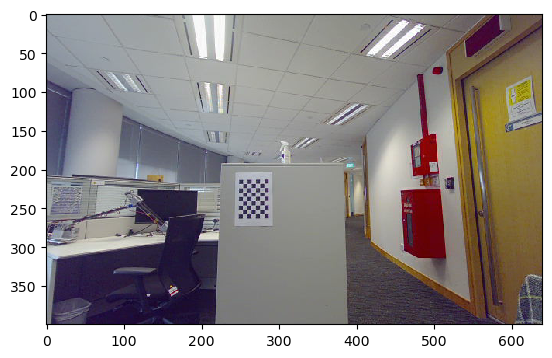

In [2]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    if wait == FRAME_INDEX:
        img = data_conversion.topic_to_image(msg)
        break
    wait += 1

plt.imshow(img)

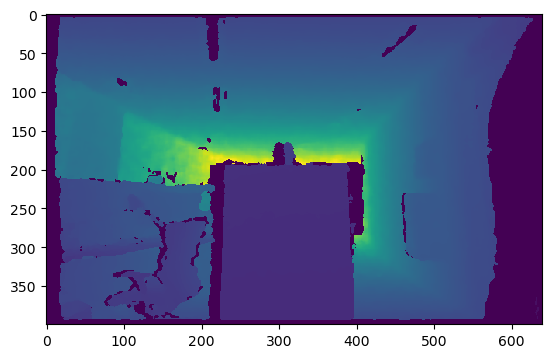

In [3]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    if wait == FRAME_INDEX:
        depth = data_conversion.topic_to_depth(msg, CAMERA_DATA)
        break
    wait += 1

plt.imshow(depth)

[ 1.08691656e+03  1.30439629e+02 -1.05536369e+00]


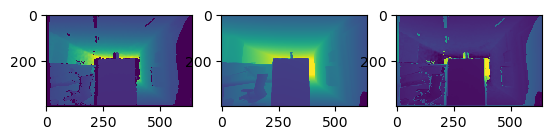

In [4]:
est_depth = MODEL.infer_image(np.array(img)) # HxW raw depth map in numpy

pred_depth, popt = depth_anything_interface.get_pred_depth(depth, est_depth, CAMERA_DATA, depth_anything_interface.estimated_depth_model, verbose=True)

fig, axs = plt.subplots(1, 3)

depth_normalised = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
pred_normalised = (pred_depth - np.min(pred_depth)) / (np.max(pred_depth) - np.min(pred_depth))

axs[0].imshow(depth_normalised)
axs[1].imshow(pred_normalised)
diff = abs(depth_normalised - pred_normalised)
axs[2].imshow(diff)

(0, 10)

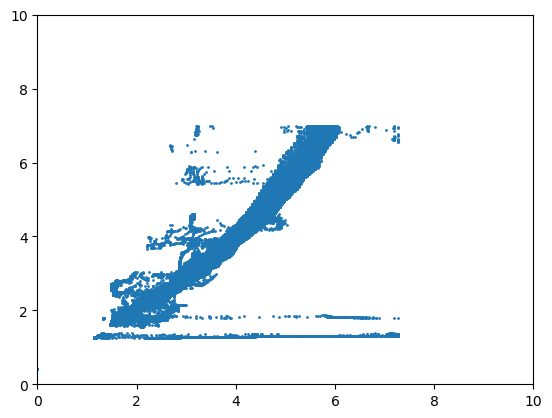

In [5]:
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
est_depth_flatten = est_depth_flatten[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]
depth_flatten = depth_flatten[(depth_flatten>=CAMERA_DATA["min_acc_range"]) & (depth_flatten<=CAMERA_DATA["max_acc_range"])]

plt.scatter(depth_anything_interface.estimated_depth_model(est_depth_flatten, *popt), depth_flatten, s=1)
#Set axis limits to be the same
plt.xlim([0, 10])
plt.ylim([0, 10])

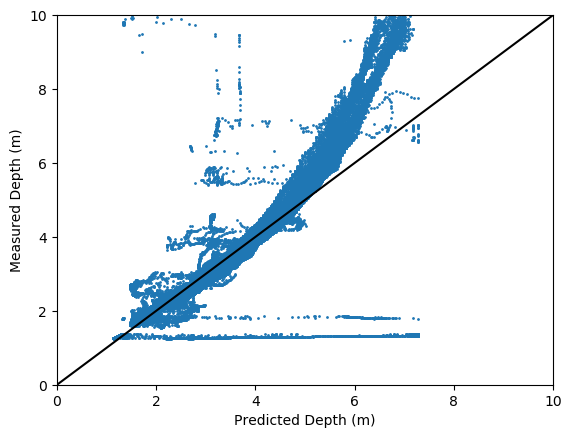

In [6]:
depth_flatten = depth.flatten()
est_depth_flatten = est_depth.flatten()
est_depth_flatten = est_depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
depth_flatten = depth_flatten[depth_flatten!=CAMERA_DATA["min_range"]]
#est_depth_flatten = est_depth_flatten[depth_flatten>=CAMERA_DATA["min_acc_range"]]
#depth_flatten = depth_flatten[depth_flatten>=CAMERA_DATA["min_acc_range"]]
#est_depth_flatten = est_depth_flatten[depth_flatten<=CAMERA_DATA["max_acc_range"]]
#depth_flatten = depth_flatten[depth_flatten<=CAMERA_DATA["max_acc_range"]]

plt.scatter(depth_anything_interface.estimated_depth_model(est_depth_flatten, *popt), depth_flatten, s=1)
#Set axis limits to be the same
plt.xlim([0, 10])
plt.ylim([0, 10])

plt.xlabel("Predicted Depth (m)")
plt.ylabel("Measured Depth (m)")

#  Draw a y=x line
plt.plot([0, 10], [0, 10], 'k-')

In [7]:
for topic, msg, t in bag.read_messages(topics=["/camera/color/camera_info"]):
    print(msg)
    D = np.array(msg.D)
    K = np.array(msg.K).reshape((3, 3))
    P = np.array(msg.P).reshape((3, 4))
    R = np.array(msg.R).reshape((3, 3))
    height = msg.height
    width = msg.width
    distortion_model = msg.distortion_model
    break

header: 
  seq: 1909
  stamp: 
    secs: 1724636113
    nsecs: 307857920
  frame_id: "camera_color_optical_frame"
height: 400
width: 640
distortion_model: "rational_polynomial"
D: [-1.0653736591339111, 0.47793787717819214, -0.000639380537904799, 0.0004882288631051779, -0.02852124534547329, -1.0467253923416138, 0.4518430233001709, -0.018296383321285248]
K: [306.4570007324219, 0.0, 319.01312255859375, 0.0, 306.4668884277344, 197.51637268066406, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [306.4570007324219, 0.0, 319.01312255859375, 0.0, 0.0, 306.4668884277344, 197.51637268066406, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 0
binning_y: 0
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: False


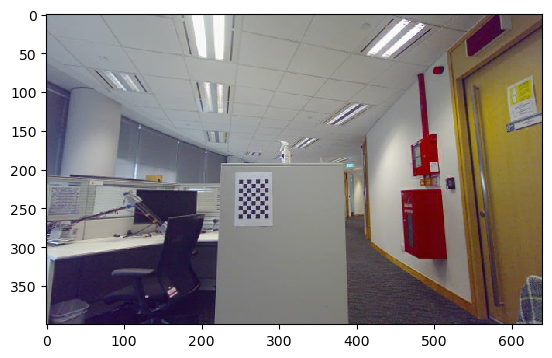

In [8]:
# Undistort image
img_undistorted = cv2.undistort(img, K, D, P)

plt.imshow(img_undistorted)

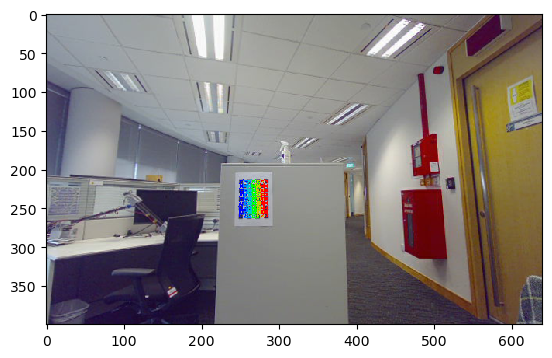

In [9]:
#Estimate distance of checkerboard
# Load camera matrix
ret, corners = cv2.findChessboardCorners(
    img_undistorted, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH)
if ret:
    fnl = cv2.drawChessboardCorners(np.float32(img_undistorted/255.0), CHECKERBOARD, corners, ret)
    plt.imshow(fnl)
else:
    print("No Checkerboard Found")
    plt.imshow(res)


In [10]:
# Prepare the object points (3D points in real world space)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE  # Scale by the size of the squares

ret, rvec, tvec = cv2.solvePnP(objp, corners, K, D)
rotation_matrix, _ = cv2.Rodrigues(rvec)
transformation_matrix = np.hstack((rotation_matrix, tvec))
transformation_matrix = np.vstack((transformation_matrix, [0, 0, 0, 1]))

In [11]:
# Find norm distance between objp and tvec

camera_estimated_depth = []
for p in objp:
    camera_estimated_depth.append(np.linalg.norm(p - tvec.reshape(3)))

camera_estimated_depth = np.array(camera_estimated_depth) / 1000

print(camera_estimated_depth)

[1.36809718 1.37323847 1.37877841 1.3847122  1.39103482 1.39774099
 1.40482521 1.41228179 1.36369471 1.36885254 1.37441015 1.38036273
 1.38670518 1.39343218 1.4005382  1.40801748 1.35970167 1.36487458
 1.37044833 1.37641804 1.38277858 1.3895246  1.39665049 1.40415049
 1.35612168 1.36130819 1.36689648 1.37288164 1.37925849 1.38602163
 1.39316545 1.4006841  1.35295801 1.3581566  1.36375781 1.36975668
 1.37614801 1.38292637 1.39008609 1.39762131 1.35021359 1.35542271
 1.36103516 1.36704598 1.37344993 1.38024154 1.38741511 1.39496476]


In [12]:
original_depth = data_conversion.interpolate_depth(depth,corners.reshape(-1, 2))
print(original_depth)

[1.33472639 1.338      1.33824954 1.34       1.34113488 1.34647914
 1.34980073 1.352      1.33148691 1.332      1.33556815 1.338
 1.34       1.344      1.348      1.34930047 1.32873291 1.331
 1.3338919  1.336      1.33992792 1.344      1.34751983 1.34916133
 1.328      1.328      1.33448312 1.336      1.33782007 1.34185152
 1.34708391 1.35180929 1.3251719  1.32657748 1.332      1.33512521
 1.33699306 1.34054144 1.34531628 1.34572655 1.32153699 1.32861571
 1.33047145 1.33324829 1.33845389 1.3412309  1.343      1.34512181]


Mean error:  0.04095098710916637
Max error:  0.06028179384358068
Standard deviation:  0.008602883224241504


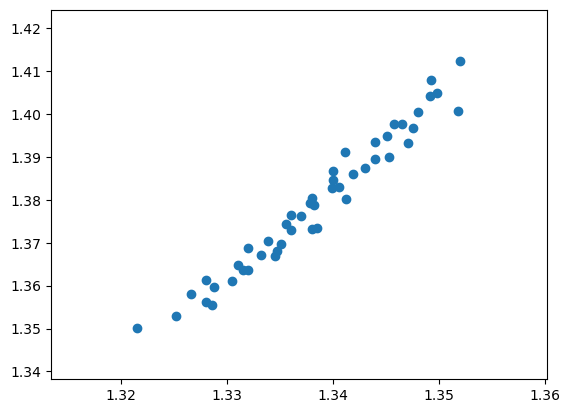

In [13]:
error = np.abs(original_depth - camera_estimated_depth)
print("Mean error: ", np.mean(error))
print("Max error: ", np.max(error))
print("Standard deviation: ", np.std(error))

plt.scatter(original_depth, camera_estimated_depth)

In [14]:
est_depth = data_conversion.interpolate_depth(pred_depth,corners.reshape(-1, 2))
print(est_depth)

[1.25028456 1.25637123 1.26257187 1.26937273 1.27501213 1.28164393
 1.28682979 1.29196686 1.24975737 1.25527118 1.26090954 1.26750422
 1.27335858 1.27929833 1.28418384 1.28888367 1.24935434 1.25466345
 1.25978737 1.26607217 1.2713416  1.27705586 1.28246127 1.28689256
 1.24933701 1.25446426 1.25962569 1.26555201 1.27060478 1.27581754
 1.28102304 1.28555806 1.24942447 1.25463385 1.25938585 1.2650244
 1.27010896 1.27486825 1.28024606 1.28507607 1.24983066 1.25534522
 1.25994791 1.26514591 1.26990002 1.27453644 1.27984664 1.28476237]


Mean error:  0.11058109245352893
Max error:  0.12031493144394667
Standard deviation:  0.005247014365757854


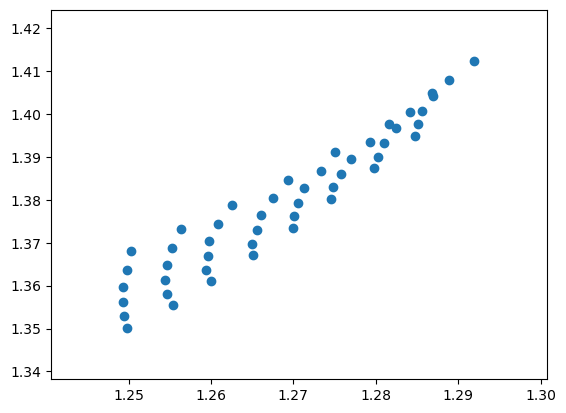

In [15]:
error = np.abs(est_depth - camera_estimated_depth)
print("Mean error: ", np.mean(error))
print("Max error: ", np.max(error))
print("Standard deviation: ", np.std(error))

plt.scatter(est_depth, camera_estimated_depth)